<a href="https://www.kaggle.com/code/jonbown/u-s-weekend-box-office-report?scriptVersionId=119914278" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import requests
from datetime import date
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
from PIL import Image
import requests
from io import BytesIO
import cv2
import string
from IPython.display import Markdown as md
from plotly.offline import init_notebook_mode, iplot, plot

In [2]:
my_date = date.today() # if date is 01/01/2018
year, week_num, day_of_week = my_date.isocalendar()
if week_num == 1:
    year = year - 1
    week_num = 52
else:
    week_num = week_num - 1
display(md(f"# **Weekend Box Office Report: {year}, Week {week_num}**"))

# **Weekend Box Office Report: 2023, Week 7**

# Data Constrution

In [3]:
#Build URL
if week_num < 10:   
    weekend_url = f'https://www.boxofficemojo.com/weekend/{year}W0{week_num}/?ref_=bo_wey_table_1'

In [4]:
#request
req=requests.get(weekend_url)
content=req.text
#Parse
soup=BeautifulSoup(content)
rows=soup.findAll('tr')

In [5]:
def getCleanTitle(title: str):
    titleClean = title.translate(str.maketrans('', '', string.punctuation))
    titleClean = titleClean.lower()
    titleW = titleClean.split(" ")
    return "_".join(titleW)

In [6]:
def getSoupRows(title: str):
    url = f'https://www.rottentomatoes.com/m/{title}'
    #request
    req=requests.get(url)
    content=req.text
    #Parse
    soup=BeautifulSoup(content)
    rows=soup.findAll('button', 'transparent trailer_play_action_button')
    return rows

In [7]:
def getImgURLFromTitle(title: str):
    clean_title = getCleanTitle(title)
    rows = getSoupRows(clean_title)
    if len(rows) == 0:
        #replace with current year function
        rows = getSoupRows(title + '_2022')
    if len(rows) == 0:
        return ''
    return rows[0].img['src']

In [8]:
weekend_data = []
#Construct table
for row in rows:
    data_row = {}
    data = row.findAll('td')
    if len(data) == 0:
        continue
    if len(data[2].findAll('span')) > 0:
        #special weekend
        data_row['occasion'] = data[2].findAll('span')[0].text
        data_row['title'] = data[2].findAll('a')[0].text
    else:
        #normal weekend
        data_row['occasion'] = ""
        data_row['title'] = data[2].text
    data_row['img_url'] = getImgURLFromTitle(data_row['title'])
    data_row['current_rank'] = int(data[0].text)
    data_row['previous_rank'] = data[1].text
    data_row['weekend_gross'] = data[3].text.replace(',', '').replace('$', '')
    data_row['weekend_chg'] = data[4].text.replace("%", '').replace('+', '').replace(',', '')
    data_row['theaters'] = data[5].text.replace(',', '')
    data_row['theater_chg'] = data[6].text.replace('+', '').replace(',', '')
    data_row['theater_avg'] = data[7].text.replace('$', '').replace(',', '')
    data_row['cumulative_gross'] = data[8].text.replace(',', '').replace('$', '')
    data_row['weeks'] = data[9].text
    data_row['distributor'] = data[10].text.strip()
    weekend_data.append(data_row)
weekend_df = pd.DataFrame(weekend_data, columns = ['current_rank','previous_rank', 'title', 'occasion', 'weekend_gross', 
                                                   'weekend_chg', 'theaters', 'theater_chg', 'theater_avg', 'cumulative_gross', 'weeks', 'distributor', 'img_url']) 

In [9]:
weekend_df.head()

,current_rank,previous_rank,title,occasion,weekend_gross,weekend_chg,theaters,theater_chg,theater_avg,cumulative_gross,weeks,distributor,img_url
0,1,-,Ant-Man and the Wasp: Quantumania,,106109650,-,4345,-,24421,106109650,1,Walt Disney Studios Motion Pictures,
1,2,2,Avatar: The Way of Water,,6550464,-9.2,2675,-390,2448,657508455,10,20th Century Studios,https://resizing.flixster.com/CLzU0r6KbnIVqeXu...
2,3,1,Magic Mike's Last Dance,,5432686,-34.6,3034,1538,1790,18023140,2,Warner Bros.,https://resizing.flixster.com/Tz39IhQKcFvyJkoO...
3,4,5,Puss in Boots: The Last Wish,,5337485,-4.3,3012,-215,1772,166153585,9,Universal Pictures,https://resizing.flixster.com/GqqIhDj1pGjTU2X3...
4,5,6,Knock at the Cabin,,3973085,-26.8,2601,-1056,1527,30445355,3,Universal Pictures,https://resizing.flixster.com/-rz7uoyvgY7KEwtz...


In [10]:
image_df = weekend_df.loc[weekend_df.img_url != ''].copy()
image_df.weekend_gross = image_df.weekend_gross.astype(float)
image_df = image_df.sort_values(by=['weekend_gross'], ascending=False)
image_df = image_df.reset_index()

In [11]:
#Normalized Revenue
image_df['rev_norm'] = image_df.weekend_gross/np.sum(image_df.weekend_gross)

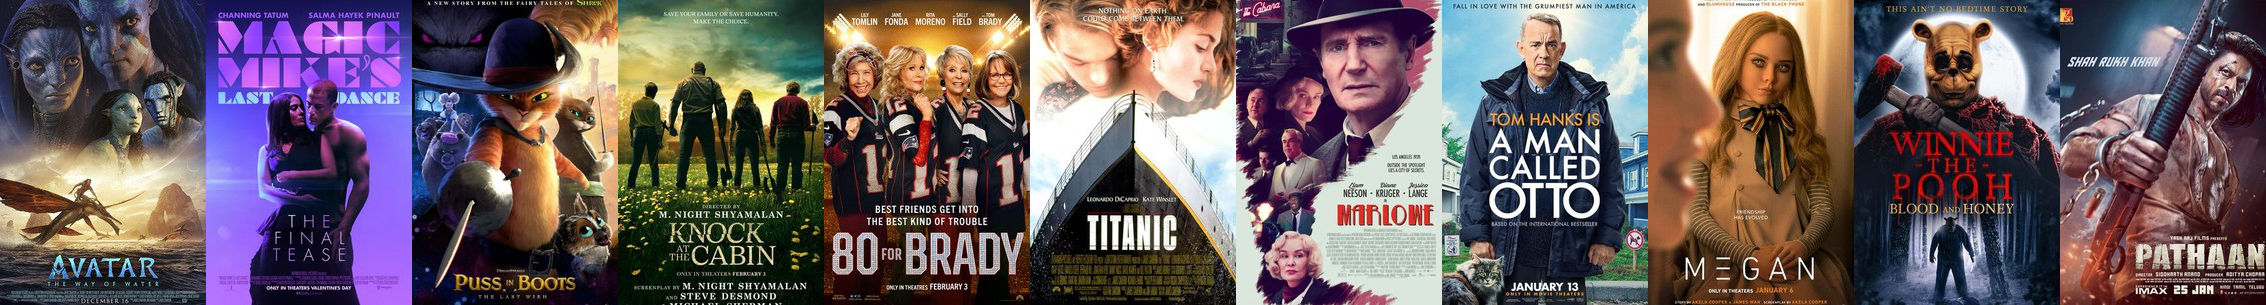

In [12]:
y_coord = 0
first_image = image_df.loc[0,'img_url']
response = requests.get(first_image)
img = Image.open(BytesIO(response.content))
for index, row in image_df.iterrows():
    if index > 10:
        break
    if index == 0:
        mergedImage = img
        continue 
    if row['img_url'] == '':
        continue
    response = requests.get(row['img_url'])
    img = Image.open(BytesIO(response.content))
    image2_size = img.size
    prev_image = mergedImage
    mergedImage = Image.new('RGB',((1+index)*image2_size[0], image2_size[1]), (250,250,250))
    mergedImage.paste(prev_image,(0,y_coord))
    mergedImage.paste(img,((index)*image2_size[0],y_coord))

mergedImage

# Move Poster - Merged By % Revenue

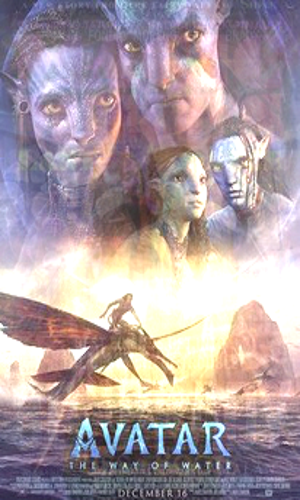

In [13]:
mergedImage = np.array([])
for index, row in image_df.iterrows():
    if index > 12:
        break
    response = requests.get(row['img_url'])
    img = Image.open(BytesIO(response.content))
    if index == 0:
        mergedImage = np.array(img)
        continue
    mergedImage = cv2.addWeighted(mergedImage, 1, np.array(img), row['rev_norm'], 0)        
img = Image.fromarray(mergedImage)

img.resize((300, 500))


# Top 5 Movies

In [14]:
top_5_df = weekend_df.loc[:5,['current_rank', 'title', 'weekend_gross']]
top_5_df.weekend_gross = top_5_df.weekend_gross.astype(int)

In [15]:
#Plot top 5 movies
import plotly.express as px

fig = px.bar(top_5_df, x="title", y="weekend_gross", title="Weekend Top 5",
                labels={
                     "weekend_gross": "Weeekend Totals (USD)",
                     "title": ""}, text_auto='.2s')
fig.update_traces(marker_color='green')
fig.show()

# Weekend Revenue Wordcloud

Titles of top movies sized by proportion of revenue at the box office

In [16]:
cloud_data = weekend_df.loc[weekend_df.cumulative_gross != '-']
title_dict = dict(zip(cloud_data.title, cloud_data.weekend_gross.astype(float)))

(-0.5, 399.5, 249.5, -0.5)

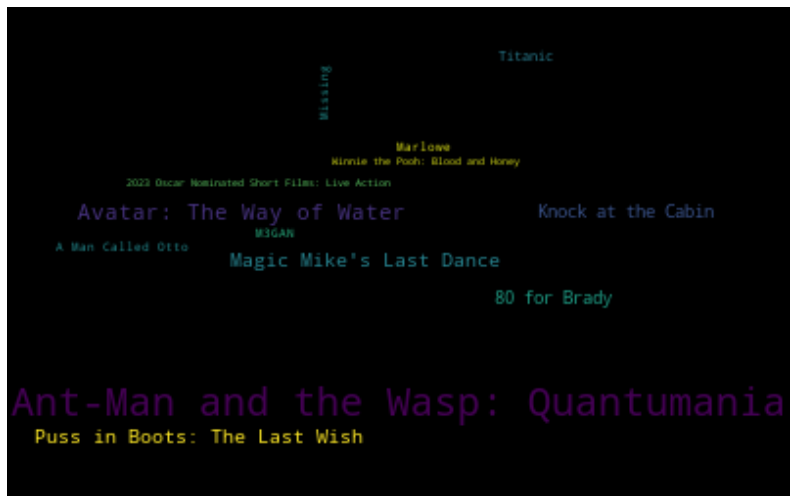

In [17]:
wc = WordCloud(width=400, height=250, min_font_size=5,
                   max_font_size=500, font_step=2)
wc.generate_from_frequencies(title_dict)
# set the word color to black
#wc.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[16,9])
# plot the wordcloud
plt.imshow(wc, interpolation="bilinear")
# remove plot axes
plt.axis("off")

# Changes in Overall Rank

These movies had larger than expected performance this last weekend

In [18]:
previous_ranked = weekend_df.loc[weekend_df.previous_rank != '-'].copy()
previous_ranked['previous_rank'] = previous_ranked.previous_rank.astype(int)
previous_ranked['current_rank'] = previous_ranked.current_rank.astype(int)
previous_ranked['rank_diff'] = previous_ranked.previous_rank - previous_ranked.current_rank
#sort by rank diff
prev_rank = previous_ranked.sort_values(by=['rank_diff'], ascending=False)

In [19]:
fig = px.bar(prev_rank.head(8),x="title", y="rank_diff", title="Positive Rank Changes",
                labels={
                     "rank_diff": "Change in Rank",
                     "title": ""
                 })

fig.show()

In [20]:
prev_rank = previous_ranked.sort_values(by=['rank_diff'])

In [21]:
fig = px.bar(prev_rank.head(8),x="title", y="rank_diff", title="Negative Rank Changes",
                labels={
                     "rank_diff": "Change in Rank",
                     "title": ""
                 })
fig.show()

# Changes in Revenue

In [22]:
weekend_jump = weekend_df.loc[weekend_df.weekend_chg != '-'].copy()
weekend_jump['weekend_chg'] = weekend_jump.weekend_chg.astype(float)
#sort by rank diff
weekend_jump = weekend_jump.sort_values(by=['weekend_chg'], ascending=False)

In [23]:
fig = px.bar(weekend_jump.head(8),x="title", y="weekend_chg", 
                         labels={
                     "weekend_chg" : "% Change in Revenue",
                     "title": ""},
             title="Weekend Revenue Increases", 
text_auto='.2s')
fig.update_traces(marker_color='crimson')
fig.show()

In [24]:
weekend_jump = weekend_df.loc[weekend_df.weekend_chg != '-'].copy()
weekend_jump['weekend_chg'] = weekend_jump.weekend_chg.astype(float)
#sort by rank diff
weekend_jump = weekend_jump.sort_values(by=['weekend_chg'])

In [25]:
fig = px.bar(weekend_jump.head(8),x="title", y="weekend_chg", title="Weekend Revenue Decreases", 
            labels={
                     "weekend_chg": "% Change in Revenue",
                     "title": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='crimson')
fig.show()

# Changes In Theater Counts

In [26]:
theater_change = weekend_df.loc[weekend_df.theater_chg != '-'].copy()
theater_change['theater_chg'] = theater_change.theater_chg.astype(int)
#sort by rank diff
theater_change = theater_change.sort_values(by=['theater_chg'], ascending=False).reset_index()

In [27]:
fig = px.bar(theater_change.head(8),x="title", y="theater_chg", title="Increase In # Of Theaters", 
            labels={
                     "theater_chg": "Change in Theater Count",
                     "title": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='crimson')
fig.show()

In [28]:
theater_change = weekend_df.loc[weekend_df.theater_chg != '-'].copy()
theater_change['theater_chg'] = theater_change.theater_chg.astype(int)
#sort by rank diff
theater_change = theater_change.sort_values(by=['theater_chg']).reset_index()
theater_change = theater_change.sort_values(by=['theater_chg']).reset_index()

In [29]:
fig = px.bar(theater_change.head(8),x="title", y="theater_chg", title="Drop in # of Theaters", 
            labels={
                     "theater_chg": "Change in Theater Count",
                     "title": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='crimson')
fig.show()

# Breakdown By Studio

In [30]:
#aggregate weekend amount by studio
studio_df = weekend_df.loc[weekend_df.distributor != '-'].copy()
studio_df['weekend_gross'] = studio_df.weekend_gross.astype(int)
studio_df = studio_df.groupby('distributor').weekend_gross.agg('sum').to_frame()
studio_df['distributor'] = studio_df.index
studio_df = studio_df.sort_values(by=['weekend_gross'], ascending=False)

In [31]:
fig = px.bar(studio_df.head(10), x="distributor", y="weekend_gross", title="Top Distributors",
                labels={
                     "weekend_gross": "Weeekend Totals (USD)",
                     "distributor": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='cyan')
fig.show()

# Longest Running Releases - Weeks In Theater

In [32]:
#Movie with weeks = maximum
weekend_df_weeks = weekend_df[weekend_df.weeks != "-"].copy()
weekend_df_weeks['weeks'] = weekend_df_weeks.weeks.astype(int)
weeks_df = weekend_df_weeks.sort_values(by=['weeks'], ascending=False)
fig = px.bar(weeks_df.head(10),x="title", y="weeks", title="Weeks in Theaters",
                labels={
                     "weeks": "Weeks in Theater",
                     "title": ""
                 })
fig.update_traces(marker_color='blue')
fig.show()


# Sources

[1] https://www.boxofficemojo.com/

[2] https://www.rottentomatoes.com/